In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from wrangle import wrangle_cars
from prepare import x_y_split, rmse, select_kbest, rfe

from scipy import stats

pd.set_option('display.max_columns', None)

import xgboost
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from hypopt import GridSearch

In [5]:
df = wrangle_cars()
df.shape

dealer column ignored
seats column ignored
Memory usage of dataframe is 341.04 MB
Memory usage after optimization is: 92.78 MB
Decreased by 72.8%


(2629427, 17)

In [9]:
df.head()

,back_legroom,city_mpg,daysonmarket,displ,dealer,front_legroom,tank_size,hwy_mpg,horsepower,length,seats,mileage,owners,price,seller_rating,wheelbase,width
0,38.093750,27.0,55.0,1500.0,True,42.00000,15.796875,36.0,160.0,193.75,5.0,42394.0,1.0,14639.0,3.447266,111.3750,73.0000
1,27.296875,18.0,36.0,3500.0,True,45.40625,17.406250,24.0,311.0,184.75,4.0,62251.0,1.0,32000.0,2.800781,107.5000,81.5000
2,38.406250,18.0,27.0,3600.0,True,41.00000,19.406250,27.0,310.0,204.25,8.0,36410.0,1.0,23723.0,3.447266,120.8750,78.6250
3,36.812500,15.0,27.0,3600.0,True,41.31250,22.000000,22.0,281.0,203.75,8.0,36055.0,1.0,22422.0,3.447266,118.8750,78.5000
4,38.593750,18.0,24.0,3600.0,True,40.31250,24.593750,25.0,295.0,189.75,5.0,25745.0,1.0,29424.0,3.447266,114.8125,84.8125


In [10]:
df = pd.get_dummies(df, columns=['dealer', 'owners'])

In [11]:
cols = ['back_legroom','city_mpg','daysonmarket','displ','front_legroom',
        'tank_size','hwy_mpg','horsepower','length','seats','mileage','seller_rating','wheelbase','width']

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = x_y_split(df, 'price')

In [13]:
mms = MinMaxScaler()

In [14]:
X_train[['back_legroom','city_mpg','daysonmarket',
         'displ','front_legroom','tank_size','hwy_mpg',
         'horsepower','length','seats','mileage',
         'seller_rating','wheelbase','width']] = mms.fit_transform(X_train[['back_legroom','city_mpg','daysonmarket',
                                                                            'displ','front_legroom','tank_size','hwy_mpg',
                                                                            'horsepower','length','seats','mileage',
                                                                            'seller_rating','wheelbase','width']])

In [15]:
X_val[['back_legroom','city_mpg','daysonmarket',
         'displ','front_legroom','tank_size','hwy_mpg',
         'horsepower','length','seats','mileage',
         'seller_rating','wheelbase','width']] = mms.transform(X_val[['back_legroom','city_mpg','daysonmarket',
                                                                            'displ','front_legroom','tank_size','hwy_mpg',
                                                                            'horsepower','length','seats','mileage',
                                                                            'seller_rating','wheelbase','width']])

In [16]:
X_test[['back_legroom','city_mpg','daysonmarket',
         'displ','front_legroom','tank_size','hwy_mpg',
         'horsepower','length','seats','mileage',
         'seller_rating','wheelbase','width']] = mms.fit_transform(X_test[['back_legroom','city_mpg','daysonmarket',
                                                                            'displ','front_legroom','tank_size','hwy_mpg',
                                                                            'horsepower','length','seats','mileage',
                                                                            'seller_rating','wheelbase','width']])

In [17]:
X_train

,back_legroom,city_mpg,daysonmarket,displ,front_legroom,tank_size,hwy_mpg,horsepower,length,seats,mileage,seller_rating,wheelbase,width,dealer_False,dealer_True,owners_1.0,owners_2.0,owners_3.0,owners_4.0,owners_5.0,owners_6.0,owners_7.0,owners_8.0,owners_9.0
1767494,0.379215,0.365854,0.050179,0.175676,0.630986,0.339616,0.450,0.113946,0.334184,0.230769,0.076079,0.929314,0.287910,0.265270,1,0,1,0,0,0,0,0,0,0,0
2555289,0.489332,0.317073,0.222222,0.121622,0.574648,0.304659,0.450,0.215986,0.394133,0.230769,0.139209,0.797644,0.322746,0.204188,1,0,1,0,0,0,0,0,0,0,0
518052,0.497591,0.439024,0.121864,0.243243,0.828169,0.433956,0.650,0.183673,0.529337,0.230769,0.613275,0.955648,0.371926,0.256545,1,0,1,0,0,0,0,0,0,0,0
822907,0.515485,0.195122,0.028674,0.391892,0.439436,0.487865,0.325,0.355442,0.644133,0.384615,0.647929,0.810118,0.566598,0.717278,0,1,1,0,0,0,0,0,0,0,0
126536,0.599449,0.219512,0.146953,0.378378,0.459155,0.474388,0.350,0.350340,0.559949,0.461538,0.201061,0.783784,0.399590,0.441536,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.435650,0.146341,0.096774,0.675676,0.467606,0.649592,0.225,0.545918,0.911990,0.307692,0.267525,0.882190,0.883197,0.462478,0,1,1,0,0,0,0,0,0,0,0
1692743,0.555403,0.487805,0.304659,0.148649,0.602817,0.304659,0.625,0.085034,0.433674,0.230769,0.181797,0.710326,0.322746,0.181501,0,1,1,0,0,0,0,0,0,0,0
2356330,0.647626,0.292683,0.017921,0.229730,0.430986,0.380047,0.400,0.171769,0.373724,0.230769,0.483675,0.801802,0.276639,0.176265,0,1,0,0,1,0,0,0,0,0,0
2229084,0.383345,0.268293,0.799283,0.175676,0.602817,0.380047,0.425,0.336735,0.440051,0.230769,0.491677,1.000000,0.371926,0.232112,1,0,0,0,1,0,0,0,0,0,0


In [14]:
lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression()

In [15]:
lm_preds = lm.predict(X_train)

In [16]:
preds = pd.DataFrame({'actual':y_train,
                      'baseline':y_train.mean(),
                      'lm_preds':lm_preds})

In [17]:
baseline_rmse = rmse(preds, 'baseline')
baseline_rmse

10887.95335368072

In [18]:
lm_rmse = rmse(preds, 'lm_preds')
lm_rmse

5645.265095635456

In [19]:
i = 0
while(i < 1):
    
    lasso = LassoLars(alpha=i)

    lasso.fit(X_train, y_train)
    
    preds['lasso_preds'] = lasso.predict(X_train)
        
    print(i)
    print(rmse(preds, 'lasso_preds'))
    
    i += .05

0
5672.87616646089
0.05
5693.464323239411
0.1
5723.7589047757765
0.15000000000000002
5786.047701151452
0.2
5852.498611704235
0.25
5906.14527420381
0.3
5919.699992398263
0.35
5934.220757605837
0.39999999999999997
5949.680663699523
0.44999999999999996
5962.771167837987
0.49999999999999994
5977.16856044733
0.5499999999999999
5993.040630598128
0.6
6010.377026443516
0.65
6029.163789448749
0.7000000000000001
6049.388068226405
0.7500000000000001
6071.036155385668
0.8000000000000002
6094.092221159768
0.8500000000000002
6117.891139927222
0.9000000000000002
6140.075243838629
0.9500000000000003
6163.44027309424


In [20]:
lasso = LassoLars(alpha=0)

lasso.fit(X_train, y_train)
    
preds['lasso_preds'] = lasso.predict(X_train)

preds.head()

,actual,baseline,lm_preds,lasso_preds
1330834,17957.0,22393.753906,17514.525391,17944.302734
88155,30997.0,22393.753906,29052.048828,29308.757812
1904413,9995.0,22393.753906,6444.899414,5907.584961
123408,37995.0,22393.753906,29679.759766,28320.308594
1211562,17800.0,22393.753906,13934.644531,13628.726562


In [21]:
lasso_rmse = rmse(preds, 'lasso_preds')
lasso_rmse

5672.87616646089

In [22]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train, y_train)

PolynomialFeatures()

In [23]:
X_polynomial = pf.transform(X_train)

In [24]:
lmtwo = LinearRegression()

lmtwo.fit(X_polynomial, y_train)

LinearRegression()

In [25]:
preds['poly_preds'] = lmtwo.predict(X_polynomial)
preds.head()

,actual,baseline,lm_preds,lasso_preds,poly_preds
1330834,17957.0,22393.753906,17514.525391,17944.302734,19498.75
88155,30997.0,22393.753906,29052.048828,29308.757812,31704.75
1904413,9995.0,22393.753906,6444.899414,5907.584961,7831.75
123408,37995.0,22393.753906,29679.759766,28320.308594,28081.75
1211562,17800.0,22393.753906,13934.644531,13628.726562,14546.25


In [26]:
poly_rmse = rmse(preds, 'poly_preds')
poly_rmse

4336.340161933794

In [27]:
lassotwo = LassoLars(alpha=0)

lassotwo.fit(X_polynomial, y_train)

LassoLars(alpha=0)

In [28]:
i = 0
while(i < 1):
    
    lassotwo = LassoLars(alpha=i)

    lassotwo.fit(X_polynomial, y_train)
    
    preds['lasso_poly'] = lassotwo.predict(X_polynomial)
        
    print(i)
    print(rmse(preds, 'lasso_poly'))
    
    i += .05

0
4505.727244296973
0.05
4954.487057203803
0.1
5154.39094365183
0.15000000000000002
5233.805881000938
0.2
5280.067991986467
0.25
5322.318479760489
0.3
5359.582259840779
0.35
5402.469065159004
0.39999999999999997
5451.160060023921
0.44999999999999996
5504.388431061166
0.49999999999999994
5556.118429263365
0.5499999999999999
5611.377371020417
0.6
5663.772417744201
0.65
5714.148580497361
0.7000000000000001
5758.334828750409
0.7500000000000001
5790.348348761066
0.8000000000000002
5818.237877570838
0.8500000000000002
5844.492450161947
0.9000000000000002
5872.211508452331
0.9500000000000003
5901.370688238454


In [30]:
lassopoly_rmse = rmse(preds, 'lasso_poly')
lassopoly_rmse

5932.236003397033

In [18]:
parameters = {'learning_rate': [.03, .07, .1, .15, .2],
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [1, 5, 15, 200],
              'subsample': [.65, 0.7, .8, .85],
              'colsample_bytree': [0.7, .8, .85],
              'n_estimators': [250, 500],
              'gamma':[0, 1, 10]}

In [19]:
xgb = xgboost.XGBRegressor()

In [20]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 4,
                        n_jobs = -1,
                        verbose=True,
                        scoring='neg_root_mean_squared_error')

In [ ]:
xgb_grid.fit(X_train,
             y_train)

print(xgb_grid.best_params_)

Fitting 4 folds for each of 7200 candidates, totalling 28800 fits


In [100]:
xgb = XGBRegressor(objective='reg:squarederror',n_estimators=20, max_depth=4, 
                   subsample=0.5, colsample_bytree=0.7, seed=42)

In [101]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [102]:
preds['xgb'] = xgb.predict(X_train)

In [103]:
xgb_rmse = rmse(preds, 'xgb')

In [104]:
rmse_df = pd.DataFrame({'model':['baseline','linear', 'lasso','linear_poly', 'lasso_poly','tweedie_norm', 'xgb'],
              'rmse':[baseline_rmse, lm_rmse, lasso_rmse, poly_rmse, lassopoly_rmse, tweedie_rmse, xgb_rmse]})

In [105]:
rmse_df.sort_values('rmse')

,model,rmse
6,xgb,4066.665587
3,linear_poly,4359.551353
1,linear,5645.265096
2,lasso,5682.859667
4,lasso_poly,5932.236003
5,tweedie_norm,10031.976387
0,baseline,10904.487775


[Text(0, 6, '4066.67'),
 Text(0, 6, '4359.55'),
 Text(0, 6, '5645.27'),
 Text(0, 6, '5682.86'),
 Text(0, 6, '5932.24'),
 Text(0, 6, '10032'),
 Text(0, 6, '10904.5')]

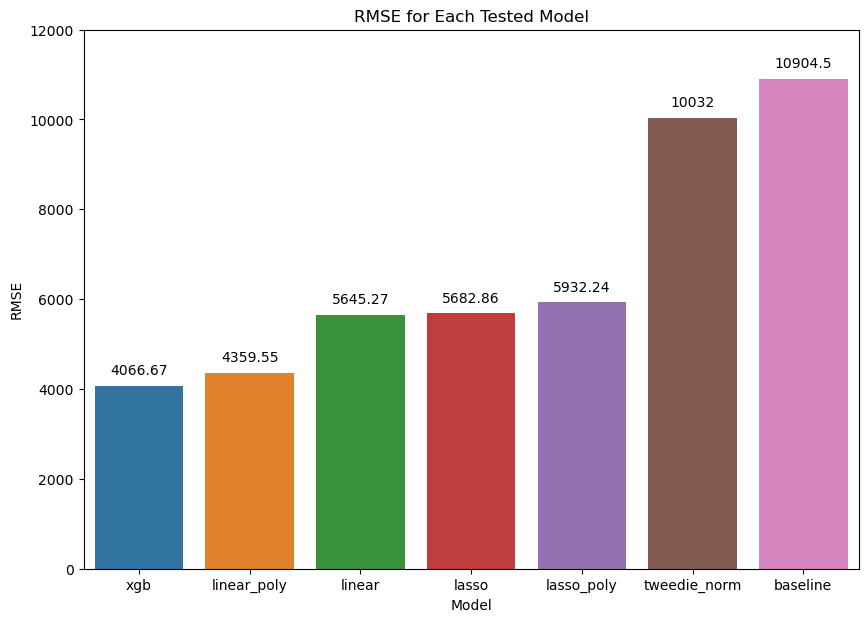

In [106]:
fig, ax = plt.subplots(figsize=(10,7))
bplot = sns.barplot(x='model',y='rmse', data=rmse_df.sort_values('rmse'))
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('RMSE for Each Tested Model')
plt.ylim(0, 12000)
ax.bar_label(bplot.containers[0], padding= 6)

In [39]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train, y_train)

PolynomialFeatures()

In [40]:
X_val_polynomial = pf.transform(X_val)

In [41]:
lmtwo = LinearRegression()

lmtwo.fit(X_polynomial, y_train)

LinearRegression()

In [42]:
val_preds = pd.DataFrame({'actual':y_val,
                          'baseline':y_train.mean()})
val_preds.head()

,actual,baseline
1756914,21988.0,22393.753906
136386,9497.0,22393.753906
818454,16999.0,22393.753906
1734593,15844.0,22393.753906
1250818,8990.0,22393.753906


In [107]:
val_preds['lasso_preds'] = lasso.predict(X_val)

val_preds['poly_preds'] = lmtwo.predict(X_val_polynomial)

val_preds['linear_preds'] = lm.predict(X_val)

val_preds['xgb_preds'] = xgb.predict(X_val)

val_preds.head()

,actual,baseline,lasso_preds,poly_preds,linear_preds,xgb_preds
1756914,21988.0,22393.753906,30171.867188,29177.25,30344.353516,29927.585938
136386,9497.0,22393.753906,10772.420898,9270.25,12089.734375,12021.298828
818454,16999.0,22393.753906,23862.324219,23065.25,23423.791016,24101.085938
1734593,15844.0,22393.753906,21951.085938,20211.75,20959.767578,20161.863281
1250818,8990.0,22393.753906,10003.435547,8194.75,8524.167969,12685.928711


In [108]:
baseline_rmse = rmse(val_preds, 'baseline')

lasso_rmse = rmse(val_preds, 'lasso_preds')

poly_rmse = rmse(val_preds, 'poly_preds')

linear_rmse = rmse(val_preds, 'linear_preds')

xgb_rmse = rmse(val_preds, 'xgb_preds')

In [109]:
val_rmse_df = pd.DataFrame({'model':['baseline', 'lasso','poly', 'linear', 'xgb'],
              'rmse':[baseline_rmse, lasso_rmse, poly_rmse, linear_rmse, xgb_rmse]})
val_rmse_df.sort_values('rmse')

,model,rmse
4,xgb,4091.321180
2,poly,4359.551353
3,linear,5655.309187
1,lasso,5682.859667
0,baseline,10904.487775


In [111]:
test_preds = pd.DataFrame({'actual':y_test,
                          'test_pred':xgb.predict(X_test)})

In [112]:
round(rmse(test_preds, 'test_pred'), 2)

4098.61